In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
batch_size = 32
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
print("Data Loaded Successfully.")

Device: cuda


100%|██████████| 26.4M/26.4M [00:03<00:00, 7.88MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 188kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.53MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.8MB/s]

Data Loaded Successfully.


In [2]:
print("Loading ResNet18")
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
def train_model(model, optimizer, num_epochs, phase_name):
    model.train()
    phase_losses = []
    print(f"Starting {phase_name}-")
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(trainloader)
        phase_losses.append(avg_loss)
        print(f"[{phase_name}] Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

    return phase_losses

Loading ResNet18
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 198MB/s]


In [3]:
optimizer_head = optim.Adam(model.fc.parameters(), lr=0.001)
history1 = train_model(model, optimizer_head, num_epochs=3, phase_name="Frozen")
print("Unfreezing layers for Fine-Tuning")
for param in model.parameters():
    param.requires_grad = True

optimizer_ft = optim.Adam(model.parameters(), lr=0.0001)
history2 = train_model(model, optimizer_ft, num_epochs=2, phase_name="Fine-Tuning")
print("Training Complete")

Starting Frozen-
[Frozen] Epoch 1/3, Loss: 0.6732
[Frozen] Epoch 2/3, Loss: 0.5274
[Frozen] Epoch 3/3, Loss: 0.4945
Unfreezing layers for Fine-Tuning
Starting Fine-Tuning-
[Fine-Tuning] Epoch 1/2, Loss: 0.2925
[Fine-Tuning] Epoch 2/2, Loss: 0.1974
Training Complete


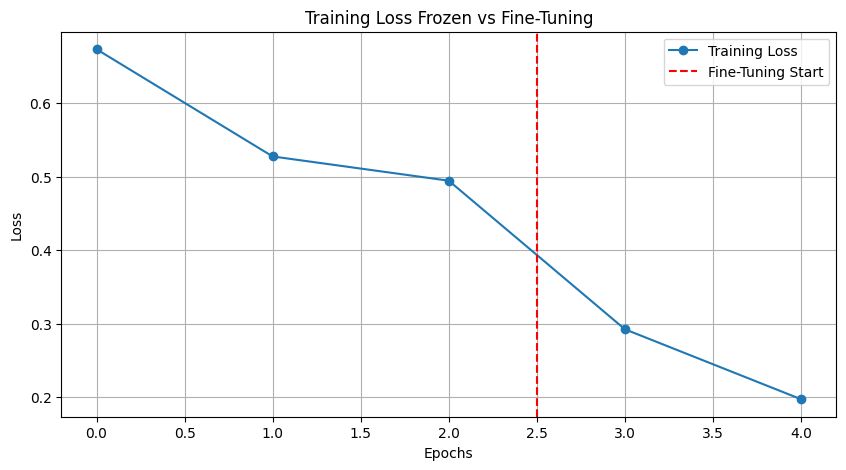

Evaluating model...

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.87      0.90      0.88      1000
     Trouser       0.98      0.99      0.99      1000
    Pullover       0.92      0.89      0.90      1000
       Dress       0.96      0.89      0.92      1000
        Coat       0.91      0.93      0.92      1000
      Sandal       1.00      0.95      0.97      1000
       Shirt       0.79      0.83      0.81      1000
     Sneaker       0.95      0.97      0.96      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.96      0.98      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



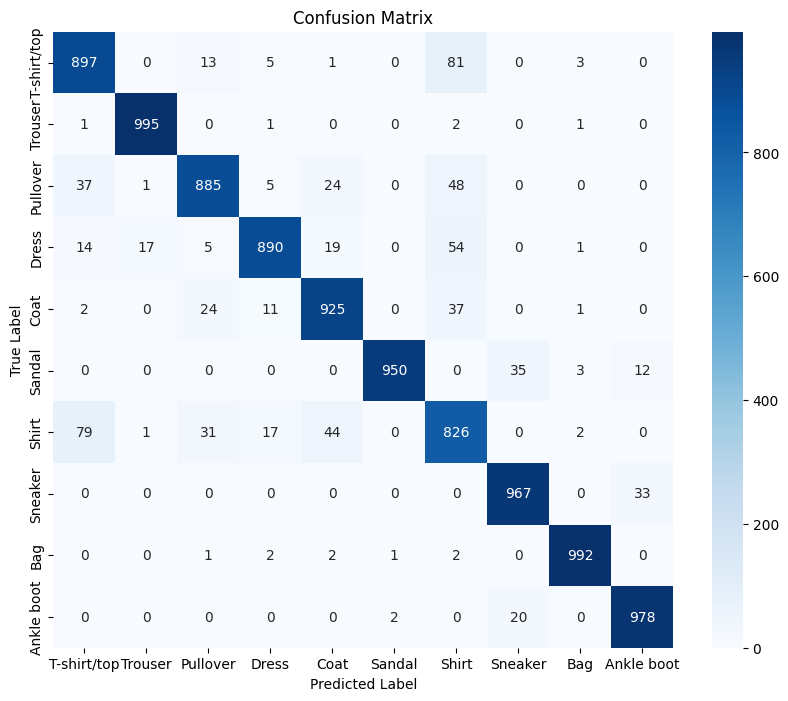

In [4]:
plt.figure(figsize=(10, 5))
full_history = history1 + history2
plt.plot(full_history, label='Training Loss', marker='o')
plt.axvline(x=2.5, color='r', linestyle='--', label='Fine-Tuning Start')
plt.title('Training Loss Frozen vs Fine-Tuning')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
print("Evaluating model...")
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=classes))
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

<div dir="rtl">

###  השוואה ומסקנות

בניתוח ההשוואתי בין מודל ה-CNN שנבנה  במטלה 4 לבין מודל ה-ResNet18 בגישת Transfer Learning (מטלה 5), ניכר יתרון ברור לגישת ה-Transfer Learning שהשיגה דיוק סופי של 93.13%, לעומת 92.19% במודל הקודם. מעבר לשיפור בדיוק, מודל ה-ResNet הפגין התכנסות מהירה ויציבה יותר, כאשר הגיע לביצועים גבוהים תוך 5 אפוקים בלבד (לעומת 10 ב-CNN), בזכות השימוש במשקולות מאומנות מראש מ-ImageNet שסיפקו למודל יכולת זיהוי מאפיינים חזקה כבר מההתחלה. עם זאת, השימוש ב-ResNet דרש משאבי חישוב משמעותיים יותר ועיבוד מקדים כבד(בהתחלה זה לא עבד לי עם cpu בכלל) , מה שהגדיל את צריכת הזיכרון והצריך שימוש ב-GPU. לסיכום, התרגיל הוכיח כי שימוש ב-Transfer Learning הוא כלי רב-עוצמה להשגת תוצאות מצטיינות בזמן אימון קצר, למרות המורכבות החישובית הנלווית.

</div>